<a href="https://colab.research.google.com/github/LeeVvin/Smart-Logistics-Competition/blob/main/%EC%8A%A4%EB%A7%88%ED%8A%B8%EB%AC%BC%EB%A5%98%EA%B3%B5%EB%AA%A8%EC%A0%84_%EC%B5%9C%EC%A2%85_%EC%9D%B4%EB%B9%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [2]:
#pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Env
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import seaborn as sns
import matplotlib.pyplot as plt
import os
from haversine import haversine # 거리측정
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import cvxpy as cp

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data load

In [5]:
%%time
url = "/content/drive/MyDrive/공모전/4학년/스마트물류/data/"
file = os.listdir(url)
file_csv = [find for find in file if find.endswith(".csv")]
print(file_csv)
flight = pd.read_csv(url+'flights.csv')
whether = pd.read_csv(url + '공모전_기상_데이터.csv')
path1 = pd.read_csv(url + '김천시청to스마트물류센터.csv')
path2 = pd.read_csv(url+'스마트물류센터to면사무소.csv')
cls = pd.read_csv(url+'clustering1.csv')
lp = pd.read_csv(url +'선형회귀자료_(김천 스마트 물류센터 ~ 한국도로공사 본사).csv')

['flights.csv', '공모전_기상_데이터.csv', '김천시청to스마트물류센터.csv', '스마트물류센터to면사무소.csv', '기상데이터_시간별_계절별_가능 일수.csv', '횟수와 일수.csv', 'clustering.csv', 'clustering1.csv', '선형회귀자료_(김천 스마트 물류센터 ~ 한국도로공사 본사).csv', '조건groupDATA.csv']


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py:1310: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 5.29 s, sys: 490 ms, total: 5.78 s
Wall time: 10.1 s


# Analysis

## 드론 데이터 EDA

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,speed,payload,altitude,date,time_day,route
0,1,0.00,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,4.0,0.0,25,2019-04-07,10:13,R5
1,1,0.20,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,4.0,0.0,25,2019-04-07,10:13,R5
2,1,0.30,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,4.0,0.0,25,2019-04-07,10:13,R5
3,1,0.50,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,4.0,0.0,25,2019-04-07,10:13,R5
4,1,0.60,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,4.0,0.0,25,2019-04-07,10:13,R5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257891,279,152.10,1.1,198.0,22.857437,0.095421,-79.782802,40.459018,271.560190,10.0,0.0,25-50-100-25,2019-10-24,10:10,R7
257892,279,152.20,1.1,196.0,22.847422,0.095421,-79.782802,40.459018,271.571983,10.0,0.0,25-50-100-25,2019-10-24,10:10,R7
257893,279,152.41,1.2,189.0,22.856186,0.111325,-79.782802,40.459018,271.584533,10.0,0.0,25-50-100-25,2019-10-24,10:10,R7
257894,279,152.60,1.1,187.0,22.854933,0.127228,-79.782802,40.459018,271.588050,10.0,0.0,25-50-100-25,2019-10-24,10:10,R7


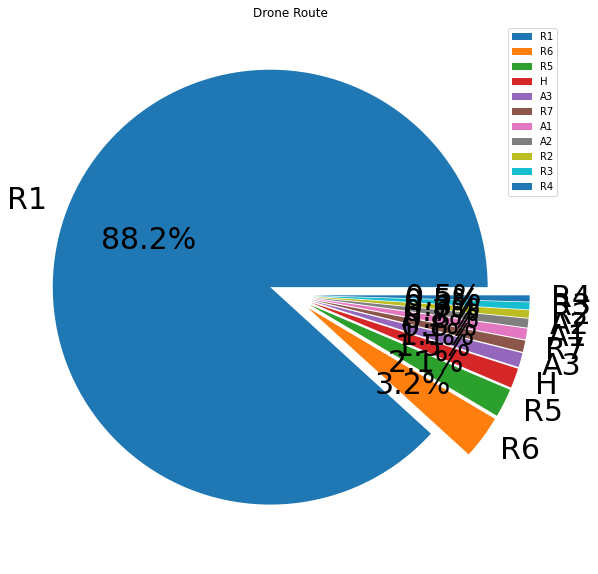

In [6]:
feat = ['flight','time','wind_speed','wind_angle','battery_voltage','battery_current','position_x','position_y','position_z','speed','payload','altitude','date','time_day','route']
display(flight[feat])
labels = ['R1','R6','R5','H','A3','R7','A1','A2','R2','R3','R4']
frequency = list(flight.route.value_counts())
pie = pd.DataFrame({'frequency':frequency},index = labels)
plt.figure(figsize=(15,10))
plt.pie(pie['frequency'],labels = labels,
        autopct = '%1.1f%%'
       ,explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
       ,textprops = {'fontsize':30})
plt.title("Drone Route")
plt.legend(labels = labels , loc='upper right')

<b><span style = "font-size :150%">A1,A2,A3,H의 경우 경로비행이 아닌 호버링 등이므로 본 과제와 상관성이 없으므로 분석에서 제외</span></b>

In [7]:
## A1,A2,A3,H는 호버링 및 기타 다른것
ROUTE = ['R1','R2','R3','R4','R5','R6','R7']
# Route 별로 r{i}에 동적변수 생성
for i in range(7):
    globals()[f"r{i+1}"] = flight[flight["route"] == ROUTE[i]]
    
display(r1.head(1))
display(r2.head(1))
display(r3.head(1))
display(r4.head(1))
display(r5.head(1))
display(r6.head(1))
display(r7.head(1))

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
9496,8,0.0,1.9,134.0,23.344486,0.047711,-79.782799,40.459023,267.935362,0.006492,...,0.001141,-0.013122,-0.178237,-9.807006,4.0,0.0,25,2019-05-06,15:56,R1


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
5490,5,0.0,0.3,255.0,24.373671,12.142359,-79.7826,40.458365,270.325344,0.004539,...,-0.021354,0.058657,0.140436,-9.819481,4.0,0.0,25,2019-04-07,11:05,R2


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
6935,6,0.0,2.0,149.0,23.495983,0.310119,-79.782601,40.458364,267.184446,0.003096,...,-0.013231,0.066581,0.103105,-9.808421,4.0,0.0,25,2019-04-07,11:18,R3


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
8299,7,0.0,0.7,210.0,24.399963,0.007952,-79.782796,40.459029,266.647237,0.001684,...,-0.004307,-0.053032,-0.079044,-9.807182,4.0,0.0,25,2019-05-06,15:43,R4


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
0,1,0.0,0.1,12.0,24.222174,0.08747,-79.782396,40.458047,269.332402,0.001772,...,0.006815,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
244515,268,0.0,3.1,44.0,25.066055,-0.166987,-79.782821,40.459057,267.902391,-0.013268,...,0.004406,-0.02939,0.246037,-9.804305,6.0,500.0,25,2019-09-19,9:54,R6


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
255711,278,0.0,1.6,154.0,24.571495,0.071566,-79.782787,40.459045,270.408412,-0.006284,...,0.01121,-0.064497,0.099577,-9.809831,10.0,500.0,25-50-100-25,2019-10-24,10:00,R7


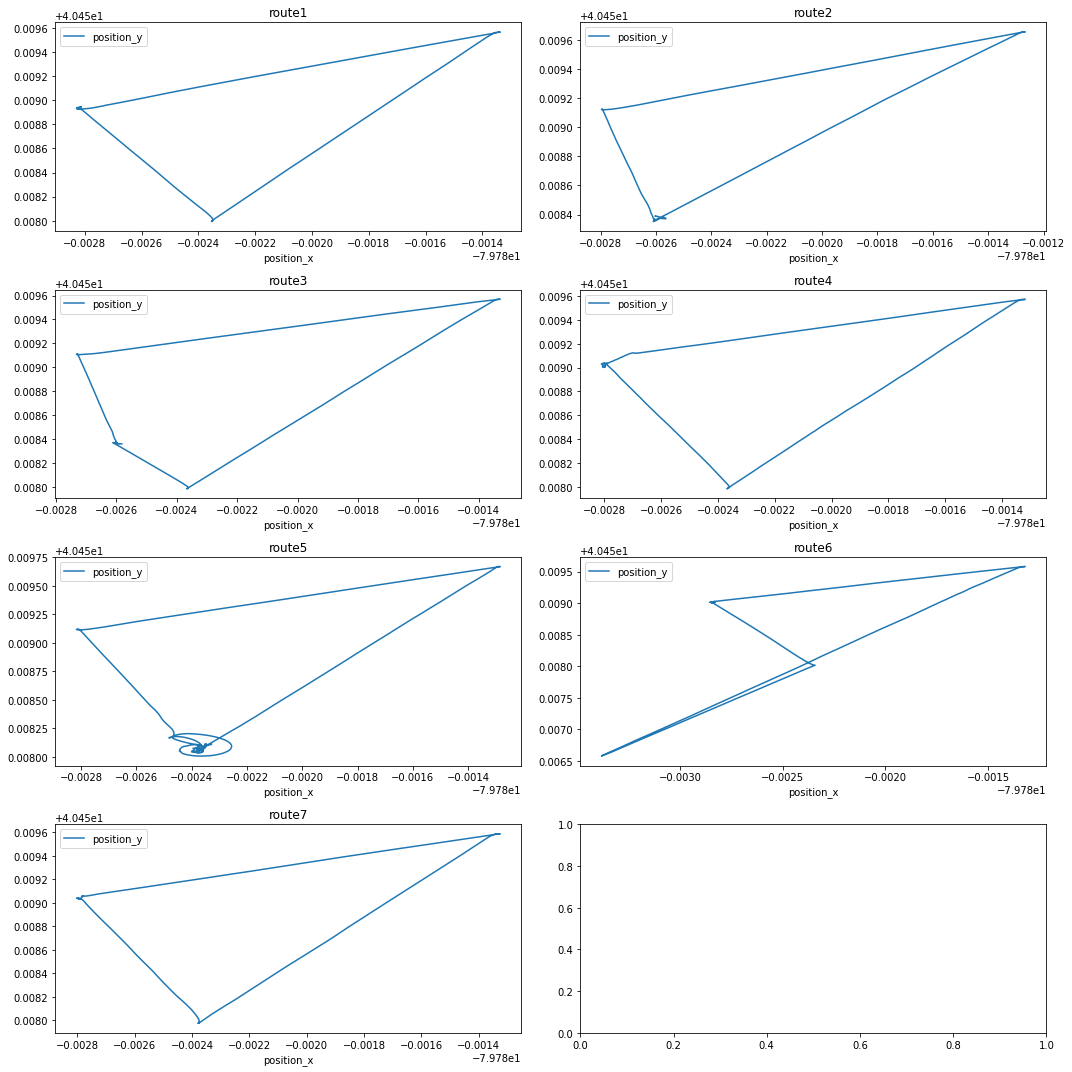

In [8]:
fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
r1[r1['flight'] ==r1.flight.value_counts().index[0]][['position_x','position_y']].plot(x='position_x',y='position_y',ax=ax[0][0],title = 'route1')
r2[r2['flight'] ==r2.flight.value_counts().index[0]][['position_x','position_y']].plot(x='position_x',y='position_y',ax=ax[0][1],title = 'route2')
r3[r3['flight'] ==r3.flight.value_counts().index[0]][['position_x','position_y']].plot(x='position_x',y='position_y',ax=ax[1][0],title = 'route3')
r4[r4['flight'] ==r4.flight.value_counts().index[0]][['position_x','position_y']].plot(x='position_x',y='position_y',ax=ax[1][1],title = 'route4')
r5[r5['flight'] ==r5.flight.value_counts().index[0]][['position_x','position_y']].plot(x='position_x',y='position_y',ax=ax[2][0],title = 'route5')
r6[r6['flight'] ==r6.flight.value_counts().index[0]][['position_x','position_y']].plot(x='position_x',y='position_y',ax=ax[2][1],title = 'route6')
r7[r7['flight'] ==r7.flight.value_counts().index[0]][['position_x','position_y']].plot(x='position_x',y='position_y',ax=ax[3][0],title = 'route7')
plt.tight_layout()

<b><span style = "font-size :150%">대부분 삼각형의 형태로 경로를 이동함</span></b>

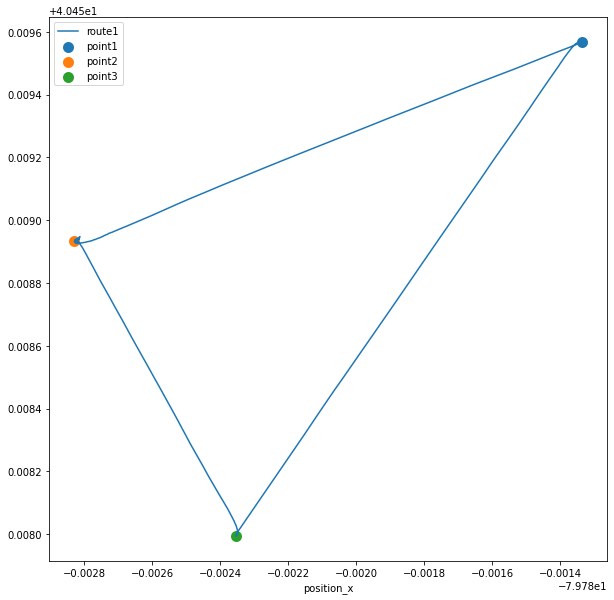

In [9]:
route_1_flight_188 = r1[r1['flight'] == 188]
route_1_flight_188.plot(x='position_x',y='position_y',figsize=(10,10))
plt.scatter(route_1_flight_188[route_1_flight_188['position_x'] ==route_1_flight_188.max()[6]]['position_x'] , route_1_flight_188[route_1_flight_188['position_x'] ==route_1_flight_188.max()[6]]['position_y'],linewidth=5)
plt.scatter(route_1_flight_188[route_1_flight_188['position_x'] ==route_1_flight_188.min()[6]]['position_x'] , route_1_flight_188[route_1_flight_188['position_x'] ==route_1_flight_188.min()[6]]['position_y'],linewidth=5)
plt.scatter(route_1_flight_188[route_1_flight_188['position_y'] ==route_1_flight_188.min()[7]]['position_x'] , route_1_flight_188[route_1_flight_188['position_y'] ==route_1_flight_188.min()[7]]['position_y'],linewidth=5)
plt.legend(['route1','point1','point2','point3'])

<b><span style = "font-size :150%">꼭짓점의 좌표를 파악 후 위,경도의 차이로 경로별 이동거리 계산</span></b>

In [10]:
# 각 루트별 가장 많이 비행한 케이스 선정
R1 = r1[r1['flight'] ==r1.flight.value_counts().index[0]]
R2 = r2[r2['flight'] ==r2.flight.value_counts().index[0]]
R3 = r3[r3['flight'] ==r3.flight.value_counts().index[0]]
R4 = r4[r4['flight'] ==r4.flight.value_counts().index[0]]
R5 = r5[r5['flight'] ==r5.flight.value_counts().index[0]]
R6 = r6[r6['flight'] ==r6.flight.value_counts().index[0]]
R7 = r7[r7['flight'] ==r7.flight.value_counts().index[0]]

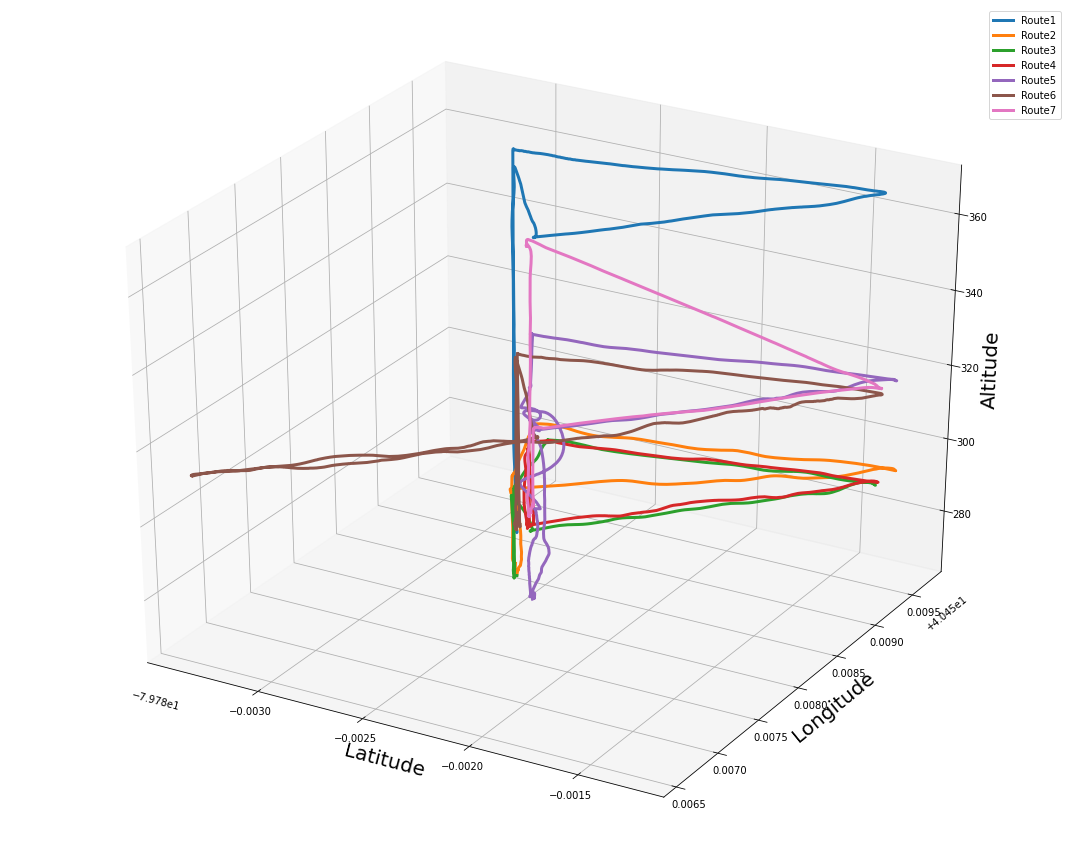

In [11]:
fig = plt.figure(figsize = (15,12))
ax = fig.gca(projection = '3d')
ax.plot(R1.position_x,R1.position_y,R1.position_z,linewidth=3)
ax.plot(R2.position_x,R2.position_y,R2.position_z,linewidth=3)
ax.plot(R3.position_x,R3.position_y,R3.position_z,linewidth=3)
ax.plot(R4.position_x,R4.position_y,R4.position_z,linewidth=3)
ax.plot(R5.position_x,R5.position_y,R5.position_z,linewidth=3)
ax.plot(R6.position_x,R6.position_y,R6.position_z,linewidth=3)
ax.plot(R7.position_x,R7.position_y,R7.position_z,linewidth=3)
plt.legend(['Route1','Route2','Route3','Route4','Route5','Route6','Route7'])
ax.set_xlabel('Latitude',fontsize=20)
ax.set_ylabel('Longitude',fontsize=20)
ax.set_zlabel('Altitude',fontsize=20)
plt.tight_layout()

<b><span style = "font-size :150%">비행별 고도도 다른것을 확인 할 수 있음</span></b>

In [12]:
data = flight[flight['flight']==1]
fig = px.bar_polar(data,r='wind_speed',theta = 'wind_angle',color = 'wind_speed',color_discrete_sequence = px.colors.sequential.Plasma_r)
fig.show()

In [13]:
fig =go.Figure()

fig.add_trace(go.Barpolar(
    r=[0 , 1.0 , 1.8],
    name = '0 - 1.8m/s',
    #marker_color = 'rgb(106, 81, 163)'
))

fig.add_trace(go.Barpolar(
    r=[2.8 , 3.2 , 3.7],
    name = '2.8 - 3.7m/s',
    #marker_color = 'rgb(158, 154, 200)'
))

fig.add_trace(go.Barpolar(
    r=[5.0, 5.5 ,5.9],
    name = '5.0 - 5.9m/s',
    #marker_color = 'rgb(1203, 201, 226)'
))

fig.add_trace(go.Barpolar(
    r=[6.4, 7.1],
    name = ' < 6.4m/s',
    #marker_color = 'rgb(242, 240, 247)'
))

fig.show()

<b><span style = "font-size :150%">드론 비행에 있어 6m/s의 풍속까지는 용인하고 있는 정도여서 풍속으로 인해 비행 데이터가 왜곡된 경우는 없음</span></b>

In [14]:
param = ['flight','speed','payload','altitude']
display(r1[param].drop_duplicates().head(15).sort_values(by = param))
display(r4[param].drop_duplicates().head(15).sort_values(by = param))

,flight,speed,payload,altitude
9496,8,4.0,0.0,25
11054,10,6.0,0.0,25
11976,12,10.0,0.0,25
12751,14,12.0,250.0,25
13459,15,10.0,250.0,25
14215,16,8.0,250.0,25
15055,17,6.0,250.0,25
15983,18,4.0,250.0,25
17118,20,8.0,250.0,50
18052,23,12.0,250.0,50


,flight,speed,payload,altitude
8299,7,4.0,0.0,25


<ipython-input-15-5b9af485eb0e>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0, 'Time')

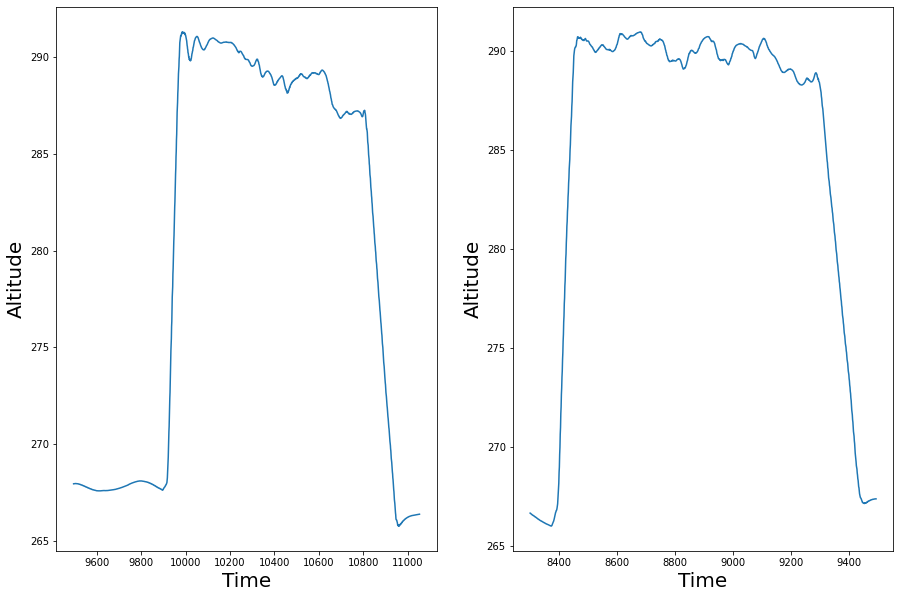

In [15]:
## 쪼개서 확인
flight1 = r1[r1.flight == 8]
flight2 = r4[r4.flight == 7]
## battery의 경우 너무 미세한 noise가 많고 0.1초 단위로 측정하므로 1초씩 가중이동평균 적용
flight1['battery'] = flight1['battery_voltage'].rolling(10).mean()
flight2['battery'] = flight2['battery_voltage'].rolling(10).mean()
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
a1 = flight1['position_z'].plot(ax=ax[0])
a2 = flight2['position_z'].plot(ax=ax[1])
a1.set_ylabel('Altitude',fontsize=20)
a1.set_xlabel('Time',fontsize=20)
a2.set_ylabel('Altitude',fontsize=20)
a2.set_xlabel('Time',fontsize=20)


In [16]:
## z의 위치(고도)에 따라 상승-크루즈-하강을 구분할 수 있응
## 고도는 매 경로마다 다르므로 기울기를 이용하여 드론의 운행 상태 확인
flight1['slope'] = flight1['position_z'].diff()
flight2['slope'] = flight2['position_z'].diff()
print(flight1.slope.head(10))
flight1['slope'] = flight1['slope'].rolling(100, min_periods = 1).mean()
flight2['slope'] = flight2['slope'].rolling(100, min_periods = 1).mean()
print(flight1.slope.head(10))

9496         NaN
9497    0.002165
9498    0.002836
9499    0.001434
9500    0.001733
9501    0.002752
9502   -0.000386
9503    0.001333
9504    0.000415
9505    0.001320
Name: slope, dtype: float64
9496         NaN
9497    0.002165
9498    0.002501
9499    0.002145
9500    0.002042
9501    0.002184
9502    0.001756
9503    0.001695
9504    0.001535
9505    0.001511
Name: slope, dtype: float64


<ipython-input-16-fbf4aa96cd86>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-fbf4aa96cd86>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CPU times: user 305 ms, sys: 242 ms, total: 547 ms
Wall time: 283 ms


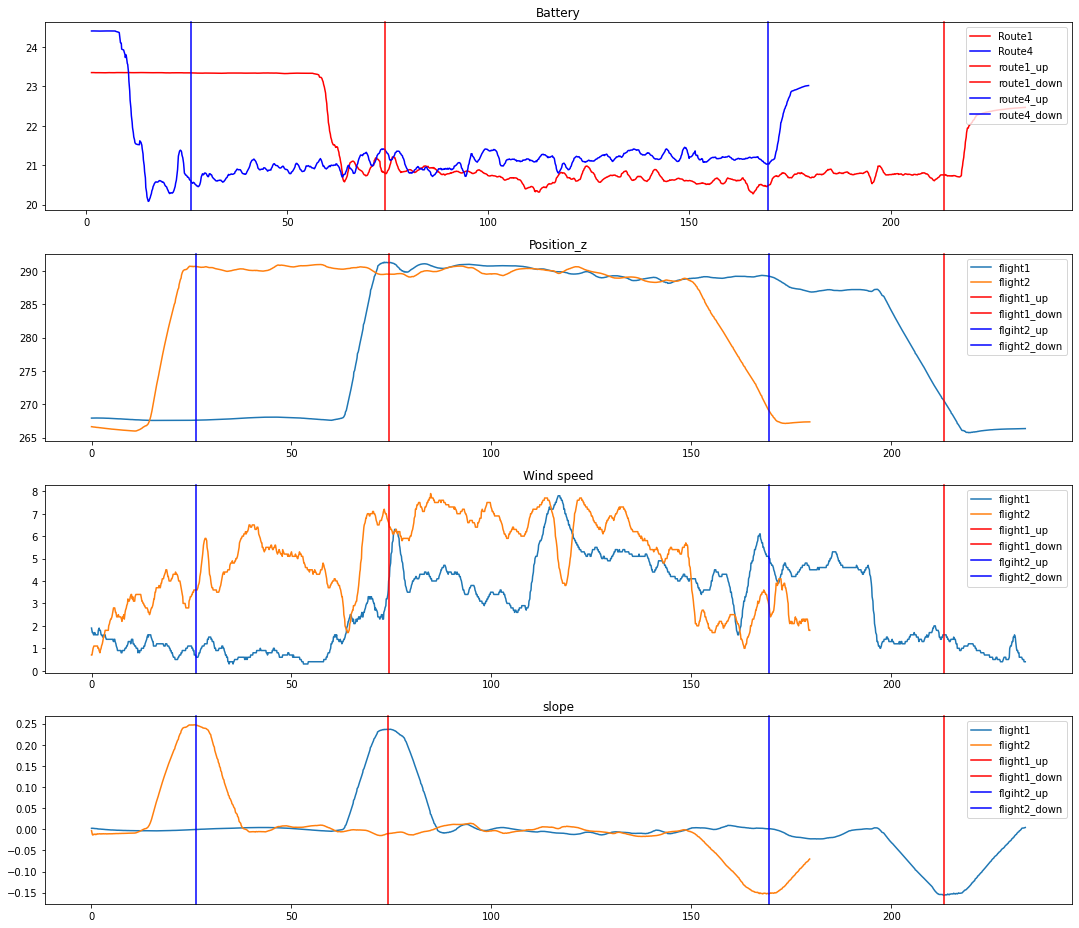

In [17]:
%%time
f1 = flight1
f2 = flight2
fig = plt.figure(figsize=(15,13))

ax1 = fig.add_subplot(411)
ax1.plot(f1.time , f1.battery,zorder=-2,color='red')
ax1.plot(f2.time , f2.battery,zorder=-2,color='blue')
# ========== 공통된 선 그리기================#
plt.axvline(x=f1.loc[f1['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f1.loc[f1['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f2.loc[f2['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='blue')
plt.axvline(x=f2.loc[f2['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='blue')
ax1.legend(['Route1','Route4','route1_up','route1_down','route4_up','route4_down'],loc='upper right')
ax1.set_title('Battery')
#-------------------------------------------#
ax2 = fig.add_subplot(412)
ax2.plot(f1.time , f1.position_z , zorder=-2)
ax2.plot(f2.time , f2.position_z , zorder=-2)
# ========== 공통된 선 그리기================#
plt.axvline(x=f1.loc[f1['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f1.loc[f1['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f2.loc[f2['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='blue')
plt.axvline(x=f2.loc[f2['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='blue')
ax2.legend(['flight1','flight2','flight1_up','flight1_down','flgiht2_up','flight2_down'],loc='upper right')
ax2.set_title("Position_z")
#-------------------------------------------#
ax3 = fig.add_subplot(413)
ax3.plot(f1.time , f1.wind_speed , zorder=-2)
ax3.plot(f2.time , f2.wind_speed , zorder=-2)
# ========== 공통된 선 그리기================#
plt.axvline(x=f1.loc[f1['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f1.loc[f1['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f2.loc[f2['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='blue')
plt.axvline(x=f2.loc[f2['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='blue')
ax3.legend(['flight1','flight2','flight1_up','flight1_down','flgiht2_up','flight2_down'],loc='upper right')
ax3.set_title("Wind speed")
#--------------------------------------------#
ax4 = fig.add_subplot(414)
ax4.plot(f1.time , f1.slope , zorder=-2)
ax4.plot(f2.time , f2.slope , zorder=-2)
# ========== 공통된 선 그리기================#
plt.axvline(x=f1.loc[f1['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f1.loc[f1['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='red')
plt.axvline(x=f2.loc[f2['slope'].idxmax()]['time'], zorder = 0, clip_on = False,color='blue')
plt.axvline(x=f2.loc[f2['slope'].idxmin()]['time'], zorder = 0, clip_on = False,color='blue')
ax4.legend(['flight1','flight2','flight1_up','flight1_down','flgiht2_up','flight2_down'],loc='upper right')
ax4.set_title("slope")

plt.tight_layout()

In [18]:
def rindex(lst, value):
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1
def bat_consumption(route,fl):
    d1 = flight[flight['route'] == route]
    data = d1[d1['flight'] == fl]
    # - - - - - - -  battery & slope - - - - - - - - - - - -
    data['battery'] = data['battery_voltage'].rolling(10, min_periods = 1).mean()
    data['slope'] = data['position_z'].diff()
    data['slope'] = data['slope'].rolling(100 , min_periods = 1).mean()
    #  - - - - - - - - - print info - - - - - - - - - - - 
    print(f"전체 배터리 양 : {list(data.iloc[0:1,:]['battery_voltage'])[0]}")
    print(f"이륙 후 배터리 양 : {data.iloc[rindex(list(data['position_z']) , max(list(data['position_z'])))]['battery']}")
    print(f"배터리 소모량: {1-round(data.iloc[rindex(list(data['position_z']),max(list(data['position_z'])))]['battery'] / list(data.iloc[0:1,:]['battery_voltage'])[0],5)}%")
    return 1-round(data.iloc[rindex(list(data['position_z']),max(list(data['position_z'])))]['battery'] / list(data.iloc[0:1,:]['battery_voltage'])[0],5)
    

In [19]:
print(bat_consumption("R1",8))
print(" = = = = = = = ")
print(bat_consumption("R4",7))

전체 배터리 양 : 23.344486236572266
이륙 후 배터리 양 : 20.91175117492676
배터리 소모량: 0.10421000000000002%
0.10421000000000002
 = = = = = = = 
전체 배터리 양 : 24.39996337890625
이륙 후 배터리 양 : 21.00765781402588
배터리 소모량: 0.13903%
0.13903


<ipython-input-18-2af207855e32>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-2af207855e32>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-2af207855e32>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 각 루트별, 비행별 분류

In [20]:
flight['battery'] = flight['battery_voltage'].rolling(10 , min_periods = 1).mean()
fl_gr = flight.groupby(['route','flight','speed','payload','altitude']).agg(max_bat = ('battery','max'),
                                   min_bat = ('battery','min'),
                                   high_z = ('position_z','max'),
                                   low_z = ('position_z','min')
                                  ).reset_index()
r = ['R1','R2','R3','R4','R5','R6','R7']
flight_gr = fl_gr[fl_gr['route'].isin(r)]
flight_gr

,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z
13,R1,8,4.0,0.0,25,23.351246,20.271453,291.321373,265.746809
14,R1,10,6.0,0.0,25,25.749174,22.679396,292.352522,266.128119
15,R1,12,10.0,0.0,25,24.397084,21.695410,290.730981,264.622492
16,R1,14,12.0,250.0,25,23.205884,20.388018,291.308826,266.251659
17,R1,15,10.0,250.0,25,24.993061,20.160270,292.670602,267.066669
...,...,...,...,...,...,...,...,...,...
205,R6,270,10.0,250.0,75,24.157317,21.014544,339.621017,265.798411
206,R6,271,10.0,0.0,25,25.529565,22.640833,289.504632,264.583044
207,R6,272,4.0,250.0,50,24.556846,21.131360,315.214555,265.134917
208,R7,278,10.0,500.0,25-50-100-25,24.566612,20.490937,365.450299,269.394920


In [21]:
flight_gr['battery_consumption'] = round(flight_gr['min_bat'] / flight_gr['max_bat'], 2)*100
flight_gr

<ipython-input-21-b5e6bef0ddf3>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
13,R1,8,4.0,0.0,25,23.351246,20.271453,291.321373,265.746809,87.0
14,R1,10,6.0,0.0,25,25.749174,22.679396,292.352522,266.128119,88.0
15,R1,12,10.0,0.0,25,24.397084,21.695410,290.730981,264.622492,89.0
16,R1,14,12.0,250.0,25,23.205884,20.388018,291.308826,266.251659,88.0
17,R1,15,10.0,250.0,25,24.993061,20.160270,292.670602,267.066669,81.0
...,...,...,...,...,...,...,...,...,...,...
205,R6,270,10.0,250.0,75,24.157317,21.014544,339.621017,265.798411,87.0
206,R6,271,10.0,0.0,25,25.529565,22.640833,289.504632,264.583044,89.0
207,R6,272,4.0,250.0,50,24.556846,21.131360,315.214555,265.134917,86.0
208,R7,278,10.0,500.0,25-50-100-25,24.566612,20.490937,365.450299,269.394920,83.0


In [22]:
display(flight_gr[flight_gr['route'] == 'R1'].sort_values(by = 'battery_consumption'))
display(flight_gr[flight_gr['route'] == 'R2'].sort_values(by = 'battery_consumption'))
display(flight_gr[flight_gr['route'] == 'R3'].sort_values(by = 'battery_consumption'))
display(flight_gr[flight_gr['route'] == 'R4'].sort_values(by = 'battery_consumption'))
display(flight_gr[flight_gr['route'] == 'R5'].sort_values(by = 'battery_consumption'))
display(flight_gr[flight_gr['route'] == 'R6'].sort_values(by = 'battery_consumption'))
display(flight_gr[flight_gr['route'] == 'R7'].sort_values(by = 'battery_consumption'))

,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
136,R1,193,4.0,500.0,50,25.343510,19.367347,320.360823,270.265778,76.0
195,R1,277,10.0,500.0,25,25.489373,19.690375,294.698053,270.088431,77.0
147,R1,204,6.0,250.0,25,24.805253,19.066353,300.723057,272.468326,77.0
31,R1,81,6.0,0.0,75,25.354402,20.172540,343.319756,268.217101,80.0
17,R1,15,10.0,250.0,25,24.993061,20.160270,292.670602,267.066669,81.0
...,...,...,...,...,...,...,...,...,...,...
112,R1,169,6.0,0.0,50,25.371180,22.998920,317.721397,265.552742,91.0
120,R1,177,10.0,0.0,25,23.603034,21.657347,293.866189,266.904580,92.0
181,R1,253,10.0,500.0,25,22.379029,20.676991,296.724930,272.579824,92.0
146,R1,203,8.0,0.0,25,23.301039,21.378015,298.427060,272.435922,92.0


,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
196,R2,5,4.0,0.0,25,23.687171,19.418806,294.64838,265.987145,82.0


,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
197,R3,6,4.0,0.0,25,23.564471,20.138359,291.141299,265.881812,85.0


,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
198,R4,7,4.0,0.0,25,24.407727,20.08089,290.981695,265.991348,82.0


,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
201,R5,3,6.0,0.0,25,25.402982,20.668728,293.471758,267.493905,81.0
202,R5,4,8.0,0.0,25,24.156440,20.795936,293.195924,267.609223,86.0
199,R5,1,4.0,0.0,25,24.225094,21.357106,295.590157,268.147224,88.0
200,R5,2,4.0,0.0,50,23.180717,20.475411,321.113125,268.196002,88.0


,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
203,R6,268,6.0,500.0,25,25.065554,19.491049,291.996881,267.014491,78.0
204,R6,269,12.0,500.0,25,25.462955,21.195841,291.413803,266.686027,83.0
207,R6,272,4.0,250.0,50,24.556846,21.131360,315.214555,265.134917,86.0
205,R6,270,10.0,250.0,75,24.157317,21.014544,339.621017,265.798411,87.0
206,R6,271,10.0,0.0,25,25.529565,22.640833,289.504632,264.583044,89.0


,route,flight,speed,payload,altitude,max_bat,min_bat,high_z,low_z,battery_consumption
208,R7,278,10.0,500.0,25-50-100-25,24.566612,20.490937,365.450299,269.394920,83.0
209,R7,279,10.0,0.0,25-50-100-25,23.561215,20.617644,365.935359,270.031556,88.0


In [23]:
def route_distance(route):
    point1 = route[route['position_x'] ==route.max()[6]][['position_x','position_y']]
    point2 = route[route['position_x'] ==route.min()[6]][['position_x','position_y']]
    point3 = route[route['position_y'] ==route.min()[7]][['position_x','position_y']]
    # R1 point1 to point2
    a = haversine(point1.values[0] , point2.values[0] , unit='m')
    # point2 to point3
    b = haversine(point2.values[0] , point3.values[0] , unit='m')
    # point3 to point1
    c = haversine(point3.values[0] , point1.values[0] , unit='m')
    return (a+b+c)

In [24]:
print(f"R1의 이동거리 : {route_distance(R1)}")
print(f"R2의 이동거리 : {route_distance(R2)}")
print(f"R3의 이동거리 : {route_distance(R3)}")
print(f"R4의 이동거리 : {route_distance(R4)}")
print(f"R5의 이동거리 : {route_distance(R5)}")
print(f"R6의 이동거리 : {route_distance(R6)}")
print(f"R7의 이동거리 : {route_distance(R7)}")

R1의 이동거리 : 339.5007015009248
R2의 이동거리 : 347.9461244273355
R3의 이동거리 : 322.0835127776607
R4의 이동거리 : 340.2414613627425
R5의 이동거리 : 349.88525127727564
R6의 이동거리 : 474.07963213507327
R7의 이동거리 : 337.7575092472613


# Feature importance

[01:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


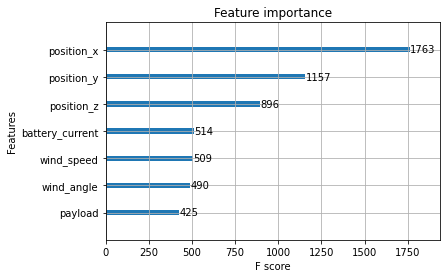

In [25]:
#flight = flight.astype({'altitude':'category'})

feat2 = ['wind_speed','wind_angle','battery_current','position_x','position_y','position_z','payload']
X = flight[feat2]
y = flight['battery'] # target
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=12)
xgb_model = xgboost.XGBRegressor(n_estimators = 100,gamma=0,colsample_bytree=1,max_depth=7)
xgb_model.fit(X_train , y_train)
xgboost.plot_importance(xgb_model)

[01:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


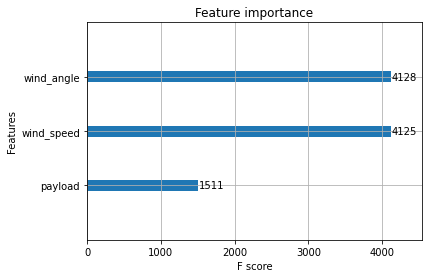

In [26]:
feat2=['wind_speed','wind_angle','payload']
# ===========================================================================================
X = flight[feat2]
y = flight['battery']# target
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=12)
xgb_model = xgboost.XGBRegressor(n_estimators = 100, gamma=0,colsample_bytree=1,max_depth=7)
xgb_model.fit(X_train , y_train)
xgboost.plot_importance(xgb_model)

#  이동거리, 배터리 소모량 회귀분석

In [27]:
def dis_cal(route,fl):
    # ------ 경로 선택--------
    d1 = flight[flight['route'] == route]
    data = d1[d1['flight'] ==fl]
    
    point1 = data[data['position_x'] == data.max()[6]][['position_x','position_y']]
    point2 = data[data['position_x'] == data.min()[6]][['position_x','position_y']]
    point3 = data[data['position_y'] == data.min()[7]][['position_x','position_y']]
    
    # R1 point1 to point2
    a = haversine(point1.values[0] , point2.values[0] , unit='m')
    # point2 to point3
    b = haversine(point2.values[0] , point3.values[0] , unit='m')
    # point3 to point1
    c = haversine(point3.values[0] , point1.values[0] , unit='m')
    
    return a+b+c

In [28]:
r1_flight = list(flight[flight['route']=='R1']['flight'].drop_duplicates())
r2_flight = list(flight[flight['route']=='R2']['flight'].drop_duplicates())
r3_flight = list(flight[flight['route']=='R3']['flight'].drop_duplicates())
r4_flight = list(flight[flight['route']=='R4']['flight'].drop_duplicates())
r5_flight = list(flight[flight['route']=='R5']['flight'].drop_duplicates())
r6_flight = list(flight[flight['route']=='R6']['flight'].drop_duplicates())
r7_flight = list(flight[flight['route']=='R7']['flight'].drop_duplicates())

In [29]:
%%time
value1 = []
value2 = []
value3 = []
value4 = []
value5 = []
value6 = []
value7 = []
for i in (r1_flight):
    x = bat_consumption("R1",i)
    value1.append(x)
for i in (r2_flight):
    x = bat_consumption("R2",i)
    value2.append(x)
for i in (r3_flight):
    x = bat_consumption("R3",i)
    value3.append(x)
for i in (r4_flight):
    x = bat_consumption("R4",i)
    value4.append(x)
for i in (r5_flight):
    x = bat_consumption("R5",i)
    value5.append(x)
for i in (r6_flight):
    x = bat_consumption("R6",i)
    value6.append(x)
for i in (r7_flight):
    x = bat_consumption("R7",i)
    value7.append(x)

<ipython-input-18-2af207855e32>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-2af207855e32>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-2af207855e32>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



전체 배터리 양 : 23.344486236572266
이륙 후 배터리 양 : 20.91175117492676
배터리 소모량: 0.10421000000000002%
전체 배터리 양 : 25.74216270446777
이륙 후 배터리 양 : 23.24882869720459
배터리 소모량: 0.09685999999999995%
전체 배터리 양 : 24.123260498046875
이륙 후 배터리 양 : 22.088928985595707
배터리 소모량: 0.08433000000000002%
전체 배터리 양 : 22.92129325866699
이륙 후 배터리 양 : 20.51898250579834
배터리 소모량: 0.10480999999999996%
전체 배터리 양 : 24.99343681335449
이륙 후 배터리 양 : 20.920014572143554
배터리 소모량: 0.16298%
전체 배터리 양 : 24.07568359375
이륙 후 배터리 양 : 21.530890274047852
배터리 소모량: 0.10570000000000002%
전체 배터리 양 : 23.17545890808105
이륙 후 배터리 양 : 21.221007537841796
배터리 소모량: 0.08433000000000002%
전체 배터리 양 : 25.48423957824707
이륙 후 배터리 양 : 22.907519721984862
배터리 소모량: 0.10111000000000003%
전체 배터리 양 : 23.16043472290039
이륙 후 배터리 양 : 21.3149112701416
배터리 소모량: 0.07967999999999997%
전체 배터리 양 : 23.4221134185791
이륙 후 배터리 양 : 21.207986259460448
배터리 소모량: 0.09453%
전체 배터리 양 : 23.402080535888672
이륙 후 배터리 양 : 22.225402450561525
배터리 소모량: 0.05027999999999999%
전체 배터리 양 : 21.11458396911621


In [30]:
%%time
dis1 = []
dis2 = []
dis3 = []
dis4 = []
dis5 = []
dis6 = []
dis7 = []
for i in (r1_flight):
    x = dis_cal("R1",i)
    dis1.append(x)
for i in (r2_flight):
    x = dis_cal("R2",i)
    dis2.append(x)
for i in (r3_flight):
    x = dis_cal("R3",i)
    dis3.append(x)
for i in (r4_flight):
    x = dis_cal("R4",i)
    dis4.append(x)
for i in (r5_flight):
    x = dis_cal("R5",i)
    dis5.append(x)
for i in (r6_flight):
    x = dis_cal("R6",i)
    dis6.append(x)
for i in (r7_flight):
    x = dis_cal("R7",i)
    dis7.append(x)

<ipython-input-27-9649fcb72597>:6: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

<ipython-input-27-9649fcb72597>:7: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

<ipython-input-27-9649fcb72597>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



CPU times: user 12.3 s, sys: 2.05 s, total: 14.3 s
Wall time: 14.5 s


In [31]:
%%time
v1 = pd.DataFrame(value1,columns = ['consumption'])
v2 = pd.DataFrame(value2,columns = ['consumption'])
v3 = pd.DataFrame(value3,columns = ['consumption'])
v4 = pd.DataFrame(value4,columns = ['consumption'])
v5 = pd.DataFrame(value5,columns = ['consumption'])
v6 = pd.DataFrame(value6,columns = ['consumption'])
v7 = pd.DataFrame(value7,columns = ['consumption'])
#==============================================
d1 = pd.DataFrame(dis1, columns = ['distance'])
d2 = pd.DataFrame(dis2, columns = ['distance'])
d3 = pd.DataFrame(dis3, columns = ['distance'])
d4 = pd.DataFrame(dis4, columns = ['distance'])
d5 = pd.DataFrame(dis5, columns = ['distance'])
d6 = pd.DataFrame(dis6, columns = ['distance'])
d7 = pd.DataFrame(dis7, columns = ['distance'])
one = pd.concat([v1,d1],axis=1)
two = pd.concat([v2,d2],axis=1)
three = pd.concat([v3,d3],axis=1)
four = pd.concat([v4,d4],axis=1)
five = pd.concat([v5,d5],axis=1)
six = pd.concat([v6,d6],axis=1)
seven = pd.concat([v7,d7],axis=1)
reg_df = flight.drop_duplicates(['flight'] , keep='first')
# 경로 1
reg_df_r1 = reg_df[reg_df['route'] =='R1'].reset_index()
sample = pd.concat([reg_df_r1,one],axis=1)
# 경로2
reg_df_r2 = reg_df[reg_df['route'] =='R2'].reset_index()
sample2 = pd.concat([reg_df_r2,two],axis=1)
# 경로3
reg_df_r3 = reg_df[reg_df['route'] =='R3'].reset_index()
sample3 = pd.concat([reg_df_r3,three],axis=1)
# 경로4
reg_df_r4 = reg_df[reg_df['route'] =='R4'].reset_index()
sample4 = pd.concat([reg_df_r4,four],axis=1)
# 경로5
reg_df_r5 = reg_df[reg_df['route'] =='R5'].reset_index()
sample5 = pd.concat([reg_df_r5,five],axis=1)
# 경로6
reg_df_r6 = reg_df[reg_df['route'] =='R6'].reset_index()
sample6 = pd.concat([reg_df_r6,six],axis=1)
# 경로7
reg_df_r7 = reg_df[reg_df['route'] =='R7'].reset_index()
sample7 = pd.concat([reg_df_r7,seven],axis=1)

merge_list = [sample,sample2,sample3,sample4,sample5,sample6,sample7]
df = pd.concat(merge_list)
df

CPU times: user 31.7 ms, sys: 0 ns, total: 31.7 ms
Wall time: 30.1 ms


,index,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,linear_acceleration_z,speed,payload,altitude,date,time_day,route,battery,consumption,distance
0,9496,8,0.0,1.9,134.0,23.344486,0.047711,-79.782799,40.459023,267.935362,...,-9.807006,4.0,0.0,25,2019-05-06,15:56,R1,23.054135,0.10421,341.361715
1,11054,10,0.0,1.3,354.0,25.742163,0.095421,-79.782807,40.459045,266.128119,...,-9.804908,6.0,0.0,25,2019-05-06,16:08,R1,22.794460,0.09686,342.628355
2,11976,12,0.0,0.7,28.0,24.123260,0.119277,-79.782824,40.459043,264.772767,...,-9.800805,10.0,0.0,25,2019-05-06,16:19,R1,24.397084,0.08433,346.034329
3,12751,14,0.0,2.1,193.0,22.921293,0.079518,-79.782826,40.459045,267.214298,...,-9.806569,12.0,250.0,25,2019-05-06,16:37,R1,23.205884,0.10481,350.804244
4,13459,15,0.0,0.8,70.0,24.993437,0.031807,-79.782808,40.459016,267.282751,...,-9.804458,10.0,250.0,25,2019-05-06,16:42,R1,22.488584,0.16298,344.041537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,247343,270,0.0,2.1,91.0,24.150806,-0.174939,-79.782825,40.459080,266.234374,...,-9.810312,10.0,250.0,75,2019-09-19,10:10,R6,24.116875,0.09493,475.032549
3,248809,271,0.0,0.7,153.0,25.524305,-0.222650,-79.782831,40.459042,265.809789,...,-9.805471,10.0,0.0,25,2019-09-19,10:22,R6,23.063400,0.08387,477.684764
4,250028,272,0.0,1.0,230.0,24.552715,-0.190843,-79.782834,40.459028,266.661198,...,-9.795166,4.0,250.0,50,2019-09-19,10:29,R6,24.449044,0.08426,474.079632
0,255711,278,0.0,1.6,154.0,24.571495,0.071566,-79.782787,40.459045,270.408412,...,-9.809831,10.0,500.0,25-50-100-25,2019-10-24,10:00,R7,24.489736,0.11054,337.757509


In [32]:
df['battery_consumption'] = df['consumption'] *100
df_show = df[['route','flight','speed','payload','altitude','distance','battery_consumption']].reset_index()
## R7 제거
df_show = df_show.iloc[0:194,:]
df_show

,index,route,flight,speed,payload,altitude,distance,battery_consumption
0,0,R1,8,4.0,0.0,25,341.361715,10.421
1,1,R1,10,6.0,0.0,25,342.628355,9.686
2,2,R1,12,10.0,0.0,25,346.034329,8.433
3,3,R1,14,12.0,250.0,25,350.804244,10.481
4,4,R1,15,10.0,250.0,25,344.041537,16.298
...,...,...,...,...,...,...,...,...
189,0,R6,268,6.0,500.0,25,470.357045,18.427
190,1,R6,269,12.0,500.0,25,474.440580,13.841
191,2,R6,270,10.0,250.0,75,475.032549,9.493
192,3,R6,271,10.0,0.0,25,477.684764,8.387


In [33]:
%%time
# OLS regression
Y = df_show['battery_consumption']
x = df_show[['speed','payload','altitude','distance']]
x = x.astype({'altitude':'float'})

model = sm.OLS(Y,x)
results = model.fit()
results.params
print(results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     battery_consumption   R-squared (uncentered):                   0.931
Model:                             OLS   Adj. R-squared (uncentered):              0.929
Method:                  Least Squares   F-statistic:                              640.3
Date:                 Thu, 09 Feb 2023   Prob (F-statistic):                   4.79e-109
Time:                         01:38:11   Log-Likelihood:                         -460.33
No. Observations:                  194   AIC:                                      928.7
Df Residuals:                      190   BIC:                                      941.7
Df Model:                            4                                                  
Covariance Type:             nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

## 경로별, 조건별 GROUPBY

In [34]:
df_show_gr = df_show.groupby('route').agg(route_bat = ('battery_consumption','mean'))
df_show_gr

,route_bat
route,
R1,9.317352
R2,16.579000
R3,12.127000
R4,13.903000
R5,11.140000
R6,11.714800


In [35]:
df_show_gr1 = df_show.groupby(['speed','payload','altitude']).agg(condition_bat_cons = ('battery_consumption','mean'))
df_show_gr1

condition_bat_cons
speed payload altitude                    
4.0   0.0     25                 12.384200
              50                  7.070333
              75                  7.059000
              100                 9.370333
              75                 11.793000
...                                    ...
12.0  500.0   25                  9.508000
              50                 10.942000
              75                  8.699333
              100                 9.591333
              25                 13.841000

[74 rows x 1 columns]

# 버스정류장 위치 선정을 위한 클러스터링

In [36]:
# def
def log_10_transform(input_df,col_lst):
    '''
    Log scaling func
    '''
    df = input_df.copy()
    for col in col_lst:
        df[col] = df[col] + 1
        df[col] = df[col].apply(np.log10)
    return df

def make_df(df,mode):
    '''
    df에 전처리된(logs, scaler(), clustering, labeling)된 input_df를 넣고 
    mode에 mean 혹은 median을 입력하면 frame 형태로 각 클러스터 별 feature들의 mean 혹은 median cnffur
    '''
    df_mean = df.groupby('cluster').mean()
    df_median = df.groupby('cluster').median()
    df_mean.reset_index(level = ['cluster'],inplace = True)
    df_median.reset_index(level = ['cluster'] , inplace = True)
    if mode =='mean':
        return df_mean.T
    if mode == 'median':
        return df_median.T
    else:
        print("ERROR")
        
def cluster_characteristic_vis(df,col):
    '''
    cluster 별로 각각의 feature의 mean값과 median값을 lineplot으로 그림,
    각각의 cluster의 feature들의 분포를 한번에 확인 가능
    '''
    # num of clusters
    num = df[col].nunique()
    cluster=[]
    cls=[]
    cls_plt=[]
    for i in range(0,num):
        tmp = df[df[col]==i]
        cluster.append(tmp)
        cl = pd.DataFrame()
        cl = cluster[i].describe().iloc[[1,5]] ##m ean and median
        cls.append(cl)
        cl_T = cls[i].T
        cls_plt.append(cl_T)
         # Visualization
        plt.rcParams.update({'font.size':13 , 'font.weight' :"bold"})
        cls[i].T.iloc[0:-1].plot.line(figsize=(10,10),title = f"cluster_{i}")
        plt.xticks(range(0,len(cls_plt[0].index)) , cls_plt[0].index , rotation = 70)
        plt.grid()
        plt.show()
        
def cluster_visualize_set(df):
    '''
    cluster 별로 각 feature들의 mean과 median 분포 확인
    여러 cluster 동시에 비교가능
    '''
    df_mean = df.groupby('cluster').mean()
    df_median = df.groupby('cluster').median()
    df_mean.reset_index(level=['cluster'] , inplace = True)
    df_median.reset_index(level=['cluster'],inplace = True)
    
    mean_t = df_mean.T.iloc[1:]
    median_t = df_median.T.iloc[1:]
    
    
    # lineplot
    plt.figure()
    plt.rcParams.update({'font.size':13 ,'font.weight':'bold'})
    ax0 = mean_t.plot.line(figsize=(10,10), title='mean_line')
    plt.xticks(range(0,len(mean_t.index)), mean_t.index , rotation = 90)
    
    plt.figure()
    plt.rcParams.update({'font.size':13 ,'font.weight':'bold'})
    ax1 = median_t.plot.line(figsize=(10,10) , title='median_line')
    plt.xticks(range(0,len(median_t.index)) , median_t.index , rotation = 90)
    
    # barplot
    plt.rcParams.update({'font.size':13 ,'font.weight':'bold'})
    ax2 = mean_t.plot.bar(figsize=(10,10), title='mean_bar')
    ax2.set_xticklabels(mean_t.index , rotation = 90)
    plt.rcParams.update({'font.size' : 13, 'font.weight' : 'bold'})
    plt.grid()
    ax2.figsize=(10,10)
    
    plt.rcParams.update({'font.size':13 ,'font.weight':'bold'})
    ax3 = median_t.plot.bar(figsize=(10,10), title='median_bar')
    ax3.set_xticklabels(median_t.index , rotation = 90)
    plt.rcParams.update({'font.size' : 13, 'font.weight' : 'bold'})
    plt.grid()
    ax3.figsize=(10,10)
    plt.tight_layout()
    plt.show()
    
def plot_radar_chart(df, cluster_id, n_clusters):
    # 변수의 수
    cls_df_sel = df.drop(cluster_id, axis=1).copy()
    categories = list(cls_df_sel)
    N = len(categories)
    
    # value 계산
    values = cls_df_sel.values
    value = values.max().max()
    # 변수의 수에 따른 angle 계산
    angles = [n / float(N) * 2 *np.pi for n in range(N)]
    angles += angles[:1]
    
    # graph figure
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111,polar = True)
    
    # x축 라벨링
    plt.xticks(angles[:-1] , categories , color = 'grey' , size = 20)
    # y축 라벨링
    
    ax.set_rlabel_position(0)
    ticks = list(range(0,10,1))
    labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
    plt.yticks(ticks , labels, color = 'grey' , size =8)
    
    color_ = plt.cm.Spectral(np.linspace(0 , 1 , n_clusters , endpoint = False))
    
    for cl_n in range(n_clusters):
        ax.plot(angles[:-1], values[cl_n] , linewidth = 2, linestyle = 'solid' ,color = color_[cl_n], label = 'cluster' + str(cl_n +1) ,alpha = 0.7)
        ax.fill(angles[:-1], values[cl_n] ,color = color_[cl_n], alpha =0.4 )
               
    plt.legend(bbox_to_anchor = (1.4 , 0.8) , fontsize = 11)
    plt.tight_layout()
    plt.show()

def plot_radar_chart_decomp2(df , cluster_id, n_clusters):
    cls_df_sel = df.drop(cluster_id, axis=1).copy()
    categories = list(cls_df_sel)
    N = len(categories)
    values = cls_df_sel.values
    value = values.max().max()
    angles = [n / float(N) *2 *np.pi for n in range(N)]
    angles += angles[:1]
    n_sub = round(n_clusters/2)
    
    color_ = plt.cm.Spectral(np.linspace(0 , 1 , n_clusters ))
    for i, cl_n in enumerate(range(n_clusters)):
        plt.figure(figsize=(15,15))
        ax = plt.subplot()
        ax = plt.subplot(n_sub , 2 , 1, polar = True)
        plt.xticks(angles[:-1], categories , color = 'grey' , size = 20)
        ax.set_rlabel_position(0)
        ticks = list(range(0,10,1))
        labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
        plt.yticks(ticks, labels, color = 'grey', size=12)
        ax.plot(angles[:-1], values[cl_n] , linewidth = 2, linestyle = 'solid', color = color_[cl_n], label = 'cluster_'+str(cl_n+1),alpha=0.7)
        ax.fill(angles[:-1], values[cl_n], color = color_[cl_n] , alpha=0.4)
        plt.legend(bbox_to_anchor = (1.4 , 0.8) ,fontsize = 12)
        plt.tight_layout()

In [37]:
df = cls.T
df.columns = ['0~9세','10~19세','20~29세','30~39세','40~49세','50~59세','60~69세','70~79세','80~89세','90~99세',
                         '100세 이상','총 인구수','면적','인구수 / 면적','풍속 평균값','드론 운행 가능 일수','드론 운행 가능 횟수','택배영업소 개수','농협 개수',
                          'gs25 개수','cu 개수','세븐일레븐 개수','이마트24 개수','편의점 개수','우체국 개수']
df = df.iloc[1:-1]
df = df.astype(int)
## 컬럼 병합
df['청년층'] = df['0~9세'] + df['10~19세'] + df['20~29세']
df['중년층'] = df['30~39세'] + df['40~49세']
df['장년층'] = df['50~59세'] + df['60~69세']
df['노년층'] = df['70~79세'] + df['80~89세']+ df['90~99세'] + df['100세 이상']
df['편의점'] = df['gs25 개수'] + df['cu 개수'] + df['세븐일레븐 개수'] + df['이마트24 개수'] + df['편의점 개수']
df['우체국'] = df['우체국 개수']
df = df[['청년층','중년층','장년층','노년층','인구수 / 면적','풍속 평균값','드론 운행 가능 일수','드론 운행 가능 횟수','택배영업소 개수','농협 개수','편의점','우체국']]
df

,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국
감문면,306,380,1428,1125,54,0,2142,17749,0,0,2,1
감천면,259,288,818,573,70,0,2205,18392,1,2,0,1
개령면,315,327,1062,720,87,0,2176,18411,0,0,0,1
구성면,267,283,1224,998,29,0,2211,18425,1,0,0,1
남면,373,474,1310,913,43,0,2191,18505,1,0,8,1
농소면,530,526,1250,796,68,0,2201,18416,0,0,4,1
대곡동,5728,4749,6956,2704,1445,0,2179,54576,1,3,22,1
대덕면,489,240,869,705,23,1,2212,16432,0,0,2,1
대신동,8663,6729,7353,2435,1073,0,2179,109152,8,2,34,2
대항면,512,481,1543,877,51,0,2155,17359,0,0,0,1


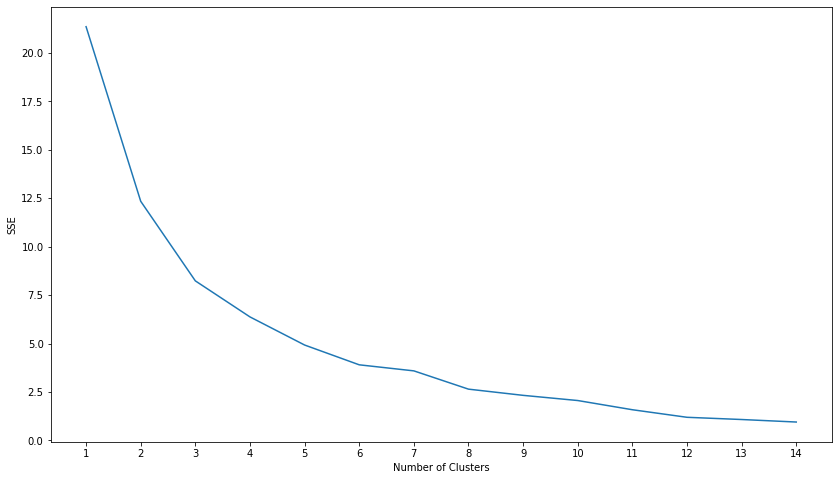

CPU times: user 592 ms, sys: 129 ms, total: 721 ms
Wall time: 513 ms


In [38]:
%%time
## 전처리 
features = df.columns.tolist()
#log_transform
log = log_10_transform(df.iloc[:,1:], features[1:])
log = log.replace(np.nan , 0)
# scaler
scaler = MinMaxScaler()
scaler.fit(log)
scaled_data = scaler.transform(log)
# Find num of k
kmeans_kwargs = {'init':'random',
                'n_init':10,
                'max_iter':200,
                'random_state':42}
sse = []
for k in range(1,15):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(14,8))
plt.plot(range(1,15),sse)
plt.xticks(range(1,15))
plt.xlabel('Number of Clusters')
plt.ylabel("SSE")
plt.show()

In [39]:
# PCA 실시
pca = PCA(n_components =2, random_state = 42)
pca.fit(scaled_data)
df_pca = pca.transform(scaled_data)
df_pca = pd.DataFrame(df_pca, columns =['com1','com2'])
# Kmeans 적용
kmeans = KMeans(n_clusters =6 ,init = 'k-means++',n_init=100,max_iter=500,random_state = 42)
kmeans.fit(scaled_data)
df_kmeans = pd.DataFrame(scaled_data, columns = features[1:])
df['cluster'] = kmeans.fit_predict(scaled_data)
df_kmeans['cluster'] = kmeans.fit_predict(scaled_data)

Text(0.5, 1.0, 'PCA')

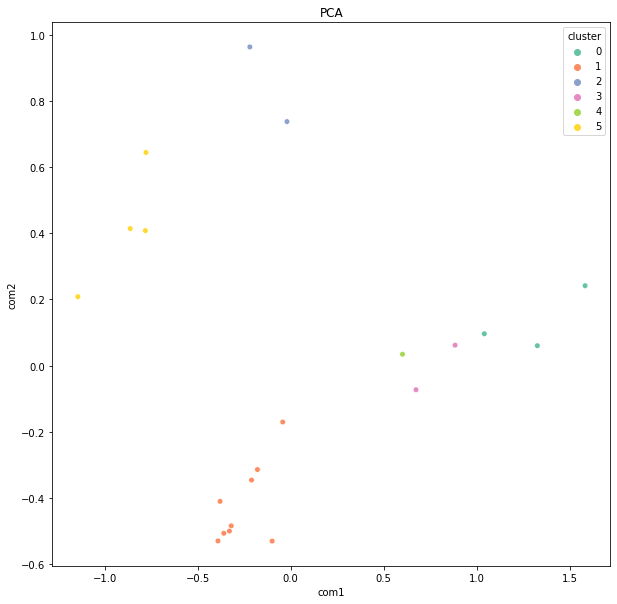

In [40]:
## make scatter plot
df_scatter = pd.concat([df_pca, df_kmeans['cluster']] ,axis =1)
plt.figure(figsize=(10,10))
scat = sns.scatterplot(x='com1',
                       y='com2',
                       s=30,
                       data=df_scatter,
                       hue = 'cluster',
                       palette = 'Set2')
scat.set_title('PCA')

In [41]:
plot_df = df.groupby('cluster').mean().reset_index()
plot_df2 = df_kmeans.groupby('cluster').mean().reset_index()
display(plot_df)
display(plot_df2)

,cluster,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국
0,0,5168.000000,4252.333333,5609.333333,2232.333333,2448.333333,0.0,2179.000000,78832.00,3.666667,2.000000,28.666667,1.333333
1,1,357.444444,387.666667,1216.666667,833.222222,53.888889,0.0,2182.333333,18112.00,0.333333,0.222222,1.777778,1.000000
2,2,1037.000000,1101.500000,2482.500000,1356.000000,104.500000,1.0,2028.000000,14752.00,2.000000,0.000000,11.000000,1.000000
3,3,1909.500000,1816.500000,2478.000000,1143.000000,750.500000,0.0,2204.500000,37348.00,2.500000,1.500000,14.000000,0.000000
4,4,9146.000000,9247.000000,4006.000000,612.000000,5351.000000,0.0,2187.000000,18417.00,0.000000,0.000000,24.000000,0.000000
5,5,205.750000,160.500000,643.250000,510.250000,19.250000,1.0,2213.750000,16311.75,0.000000,0.000000,6.500000,0.750000


,cluster,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국
0,0,0.777237,0.859085,0.894894,0.830827,0.0,0.880027,0.827518,0.605155,0.764160,0.949258,0.753953
1,1,0.278623,0.318745,0.425494,0.220301,0.0,0.889022,0.153868,0.105155,0.088053,0.187632,0.630930
2,2,0.496648,0.571967,0.661621,0.323987,1.0,0.424478,0.054258,0.500000,0.000000,0.672103,0.630930
3,3,0.564781,0.561091,0.585729,0.650396,0.0,0.951263,0.494829,0.565465,0.646241,0.751310,0.000000
4,4,1.000000,0.772129,0.286237,1.000000,0.0,0.902526,0.161883,0.000000,0.000000,0.905362,0.000000
5,5,0.077310,0.078045,0.181143,0.054705,1.0,0.977157,0.104608,0.000000,0.000000,0.374979,0.473197


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

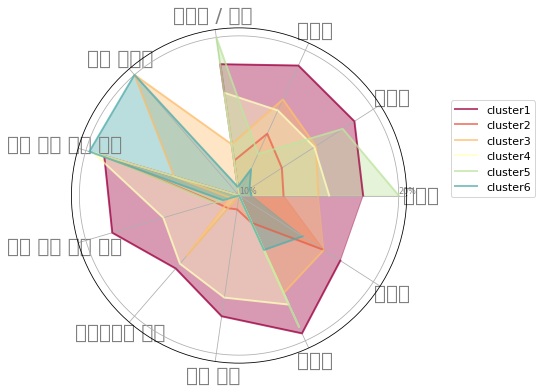

In [42]:
plt.rc('font', family = 'Malgun Gothic')
plot_radar_chart(plot_df2,'cluster',6)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

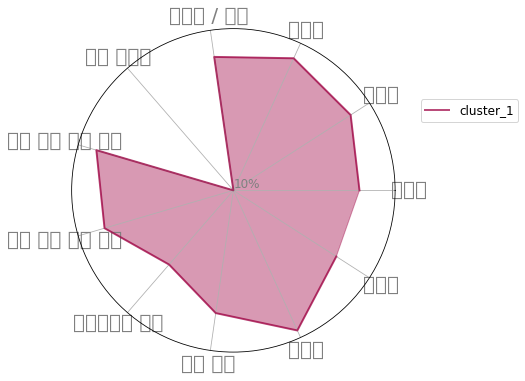

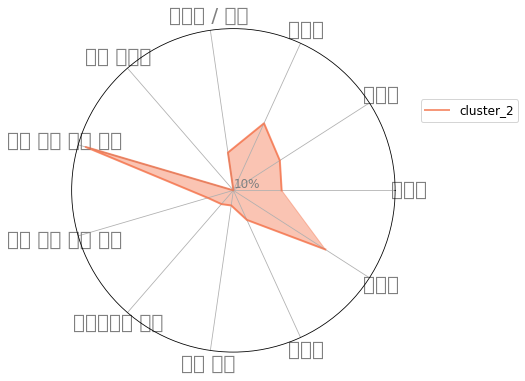

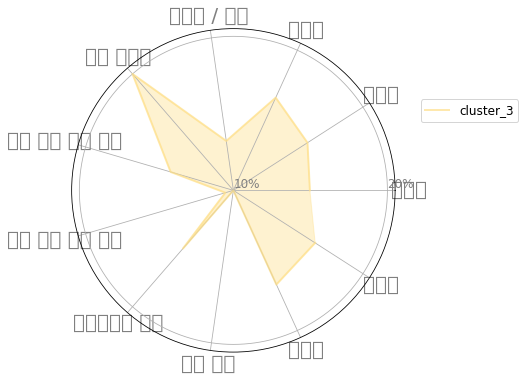

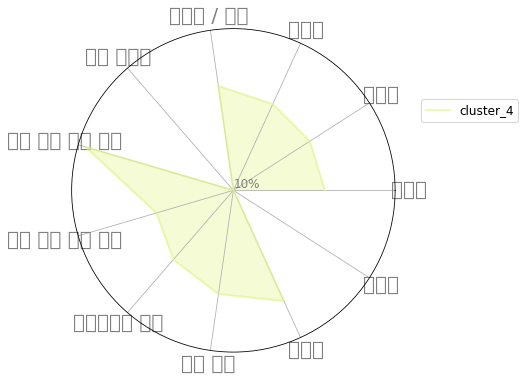

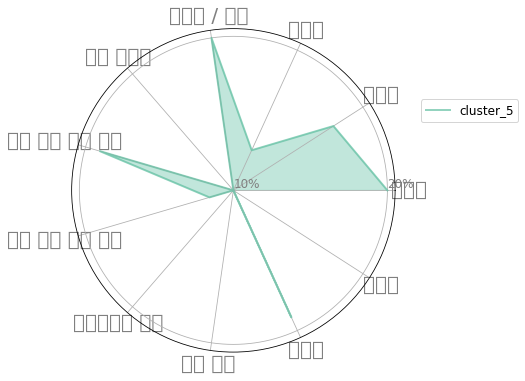

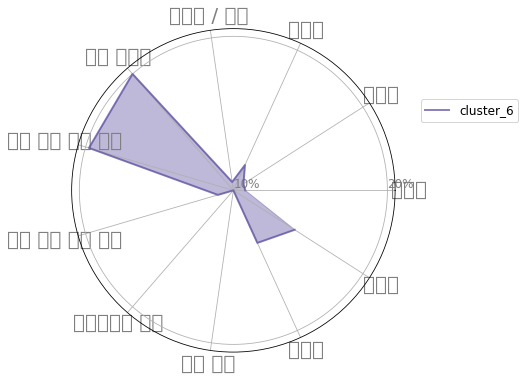

In [43]:
plot_radar_chart_decomp2(plot_df2,'cluster',6)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

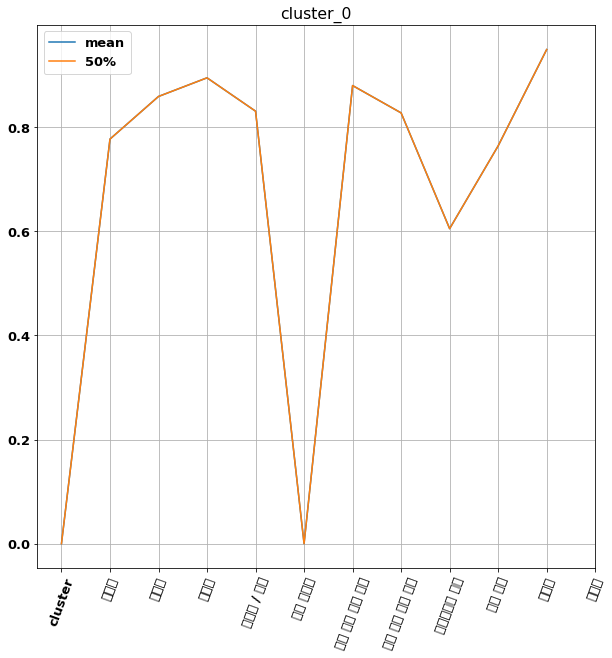

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

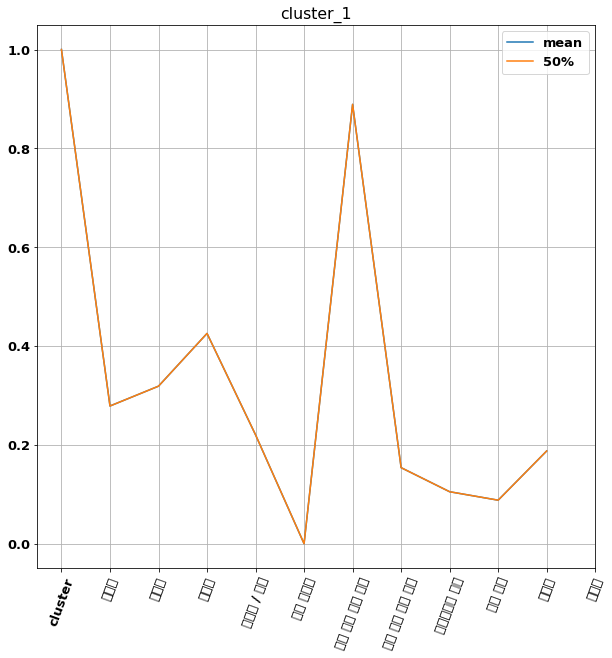

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

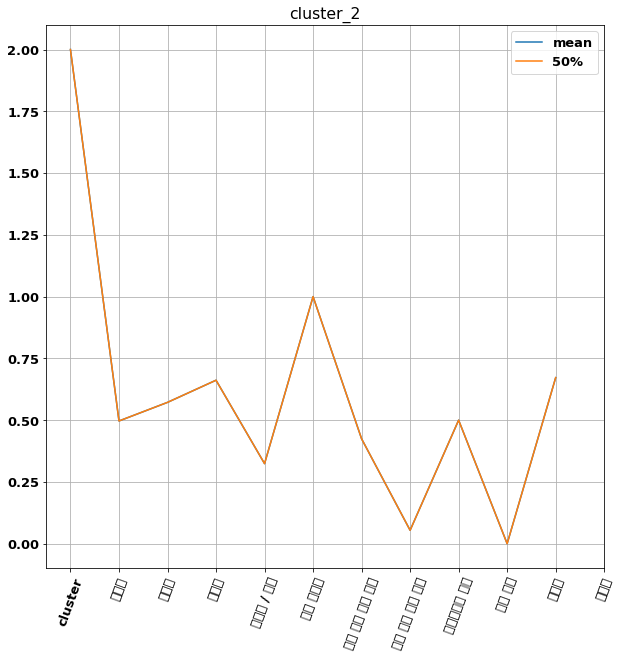

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

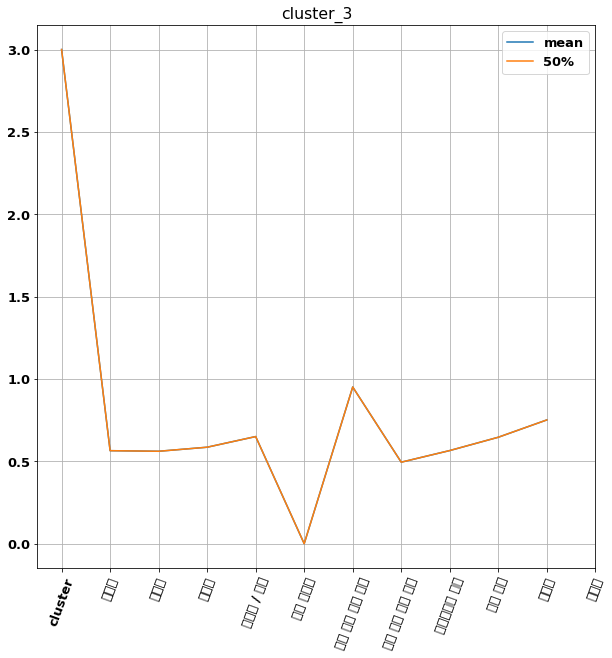

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

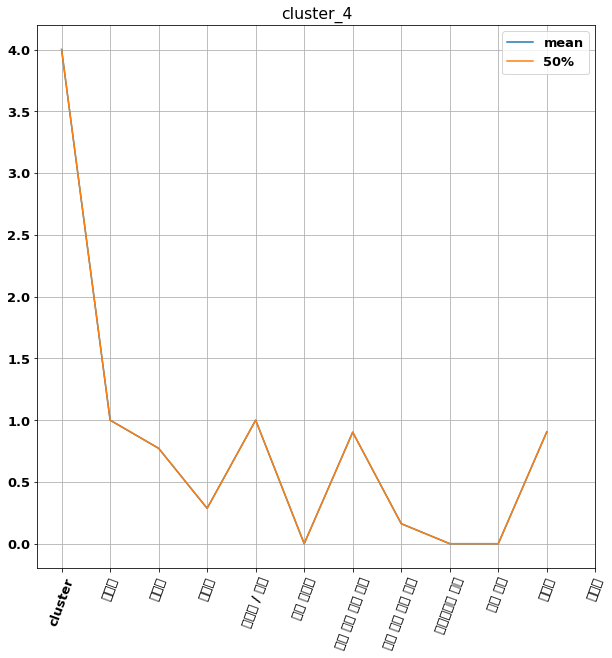

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

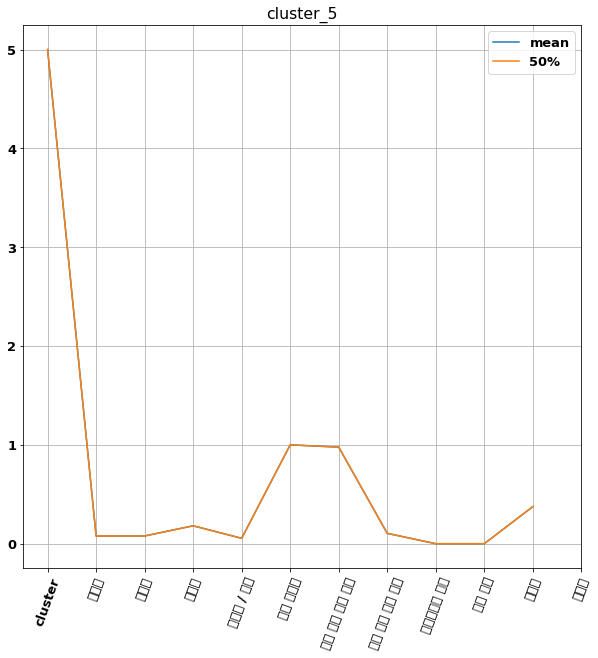

In [44]:
cluster_characteristic_vis(plot_df2,'cluster')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 51473 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 45380 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 52789 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 51109 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 45432 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 51064 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44396 missing from current font.

/usr/local/lib/python3.8/dist-packages/matplotli

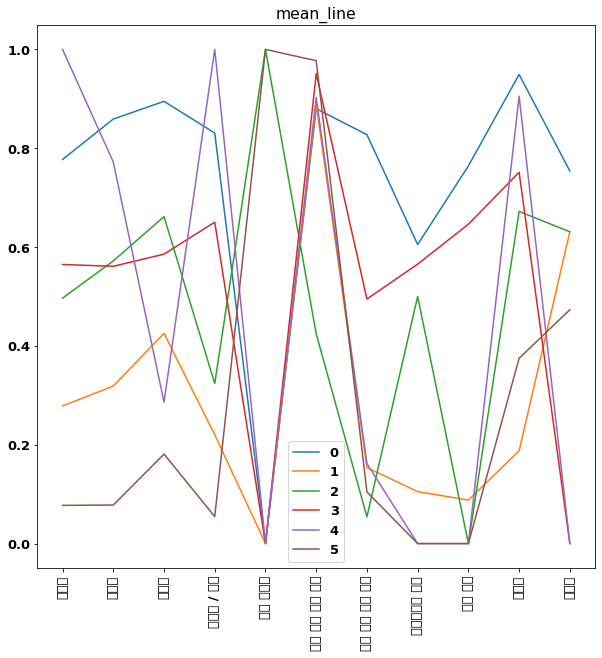

<Figure size 432x288 with 0 Axes>

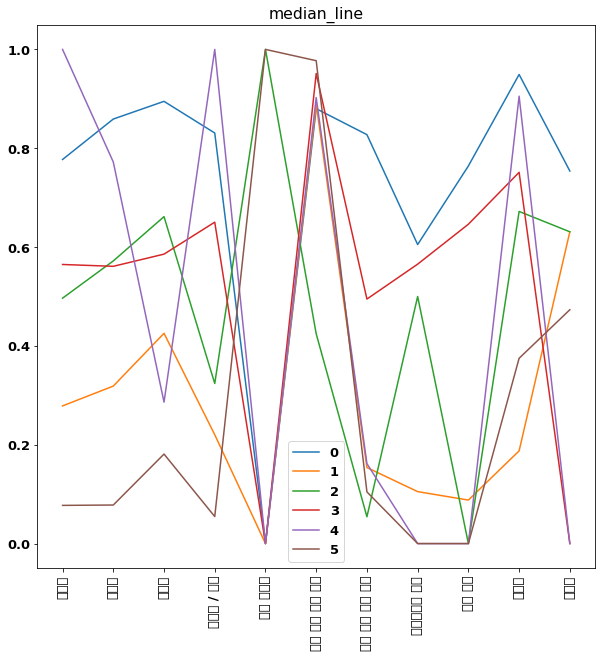

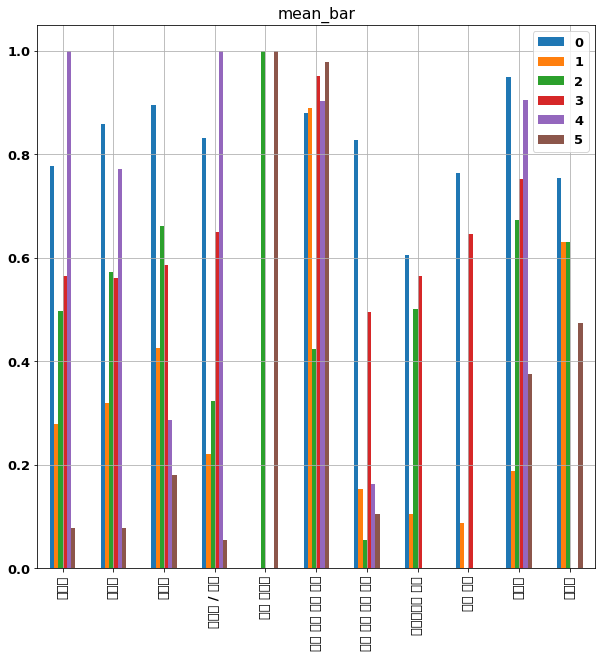

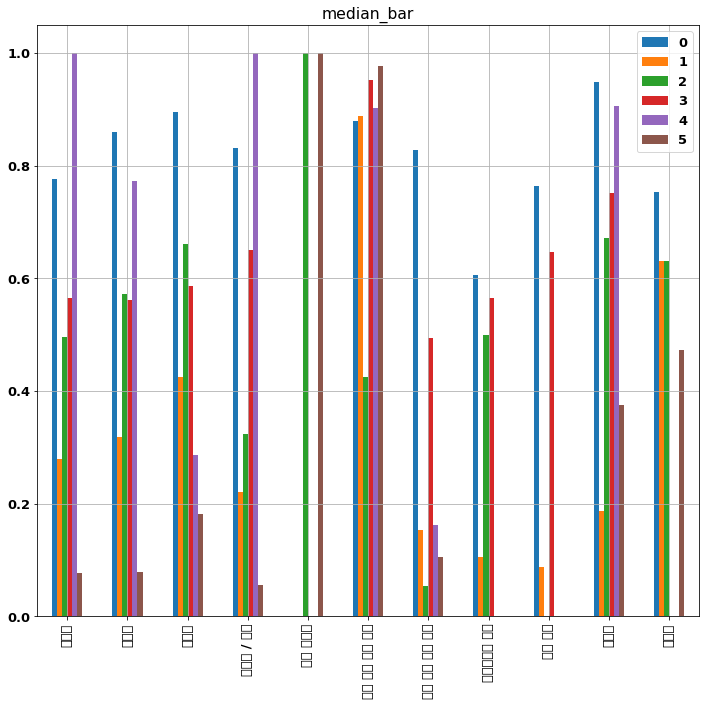

In [45]:
cluster_visualize_set(plot_df2)

In [46]:
make_df(df,'mean')

,0,1,2,3,4,5
cluster,0.000000,1.000000,2.0,3.0,4.0,5.00
청년층,5168.000000,357.444444,1037.0,1909.5,9146.0,205.75
중년층,4252.333333,387.666667,1101.5,1816.5,9247.0,160.50
장년층,5609.333333,1216.666667,2482.5,2478.0,4006.0,643.25
노년층,2232.333333,833.222222,1356.0,1143.0,612.0,510.25
인구수 / 면적,2448.333333,53.888889,104.5,750.5,5351.0,19.25
풍속 평균값,0.000000,0.000000,1.0,0.0,0.0,1.00
드론 운행 가능 일수,2179.000000,2182.333333,2028.0,2204.5,2187.0,2213.75
드론 운행 가능 횟수,78832.000000,18112.000000,14752.0,37348.0,18417.0,16311.75
택배영업소 개수,3.666667,0.333333,2.0,2.5,0.0,0.00


In [47]:
make_df(df,'median')

,0,1,2,3,4,5
cluster,0.0,1.0,2.0,3.0,4.0,5.0
청년층,5728.0,315.0,1037.0,1909.5,9146.0,129.5
중년층,4749.0,380.0,1101.5,1816.5,9247.0,146.5
장년층,6956.0,1250.0,2482.5,2478.0,4006.0,596.5
노년층,2435.0,822.0,1356.0,1143.0,612.0,499.5
인구수 / 면적,1445.0,53.0,104.5,750.5,5351.0,18.5
풍속 평균값,0.0,0.0,1.0,0.0,0.0,1.0
드론 운행 가능 일수,2179.0,2191.0,2028.0,2204.5,2187.0,2213.5
드론 운행 가능 횟수,72768.0,18392.0,14752.0,37348.0,18417.0,16378.0
택배영업소 개수,2.0,0.0,2.0,2.5,0.0,0.0


In [48]:
display(df[df.cluster ==0])
display(df[df.cluster ==1])
display(df[df.cluster ==2])
display(df[df.cluster ==3])
display(df[df.cluster ==4])
display(df[df.cluster ==5])

,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국,cluster
대곡동,5728,4749,6956,2704,1445,0,2179,54576,1,3,22,1,0
대신동,8663,6729,7353,2435,1073,0,2179,109152,8,2,34,2,0
자산동,1113,1279,2519,1558,4827,0,2179,72768,2,1,30,1,0


,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국,cluster
감문면,306,380,1428,1125,54,0,2142,17749,0,0,2,1,1
감천면,259,288,818,573,70,0,2205,18392,1,2,0,1,1
개령면,315,327,1062,720,87,0,2176,18411,0,0,0,1,1
구성면,267,283,1224,998,29,0,2211,18425,1,0,0,1,1
남면,373,474,1310,913,43,0,2191,18505,1,0,8,1,1
농소면,530,526,1250,796,68,0,2201,18416,0,0,4,1,1
대항면,512,481,1543,877,51,0,2155,17359,0,0,0,1,1
봉산면,420,444,1341,822,53,0,2155,17359,0,0,0,1,1
조마면,235,286,974,675,30,0,2205,18392,0,0,2,1,1


,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국,cluster
아포읍,1475,1579,3284,1581,148,1,2168,16444,2,0,6,1,2
어모면,599,624,1681,1131,61,1,1888,13060,2,0,16,1,2


,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국,cluster
양금동,583,593,1513,1091,409,0,2222,37862,3,2,10,0,3
지좌동,3236,3040,3443,1195,1092,0,2187,36834,2,1,18,0,3


,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국,cluster
율곡동,9146,9247,4006,612,5351,0,2187,18417,0,0,24,0,4


,청년층,중년층,장년층,노년층,인구수 / 면적,풍속 평균값,드론 운행 가능 일수,드론 운행 가능 횟수,택배영업소 개수,농협 개수,편의점,우체국,cluster
대덕면,489,240,869,705,23,1,2212,16432,0,0,2,1,5
부항면,104,143,546,439,14,1,2210,15775,0,0,22,1,5
증산면,75,109,511,337,13,1,2218,16716,0,0,0,1,5
지례면,155,150,647,560,27,1,2215,16324,0,0,2,0,5


# Linear programming

In [49]:
# data load
df = lp.replace(np.nan, 0)
df['ID'] = df['경로'].astype(str) + ' _ ' +df['버스 '].astype(str)+ ' _ ' + df['승차'] + df['승차 정류장 번호'].astype(str) + ' _ ' + df['하차 정류장 번호'].astype(str) +df['하차']
df = df[['ID','승차 버스정류장까지 거리','버스에서 걸리는 시간(분)','배차간격','차량 운행 횟수','노선별이용량','노선굴곡도']]
df

,ID,승차 버스정류장까지 거리,버스에서 걸리는 시간(분),배차간격,차량 운행 횟수,노선별이용량,노선굴곡도
0,1 _ 23-2 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,24,1,0.0,1.40
1,1 _ 22-1 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,5,2,172.0,1.30
2,1 _ 22-2 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,24,1,204.0,2.70
3,1 _ 22-3 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,7,2,218.0,1.30
4,1 _ 22-4 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,24,1,76.0,3.10
5,1 _ 22-5 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,3,2,147.0,1.50
6,1 _ 22-7 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,3,3,348.0,1.30
7,1 _ 22-8 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,8,2,209.0,1.74
8,1 _ 23 _ 남산14675 _ 16049김천시외버스터미널,1.5,18,24,1,114.0,1.40
9,2 _ 22-1 _ 남산14675 _ 14041김천시외버스터미널,1.5,18,5,2,172.0,1.30


In [50]:
df = df.astype({'승차 버스정류장까지 거리':'int'
               ,'버스에서 걸리는 시간(분)':'int'
               ,'배차간격':'int'
               ,'차량 운행 횟수':'int'
               ,'노선별이용량':'int'
               ,'노선굴곡도':'int'})

In [51]:
## variable
a = df[['승차 버스정류장까지 거리']]
b = df[['버스에서 걸리는 시간(분)']]
c = df[['배차간격']]
d = df[['차량 운행 횟수']]
e = df[['노선별이용량']]
f = df[['노선굴곡도']]

In [52]:
a = cp.Variable(a.index.size)
b = cp.Variable(b.index.size)
c = cp.Variable(c.index.size)
d = cp.Variable(d.index.size)
e = cp.Variable(e.index.size)
f = cp.Variable(f.index.size)

In [53]:
# 조건 생성
constraints = [
    a <=1.5,
    b <= 18.8,
    c <= 15,
    d >= 1,
    e <=192,
    f <=1.6
    
]
# 문제의 정의 개선 ver
#obj2 = cp.Minimize(cp.sum(a*30 + b+c-d+e+f))

# 문제의 정의
obj = cp.Minimize(cp.sum(df['승차 버스정류장까지 거리']*30 +df['버스에서 걸리는 시간(분)'] +df['배차간격'] - df['차량 운행 횟수'] + df['노선별이용량'] + df['노선굴곡도']))
    
prob = cp.Problem(obj, constraints)
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value 12151.0


In [54]:
print(f" 승차버스정류장까지의 거리 : {a.value[0]}")
print(f" 버스에서 걸리는 시간 : {b.value[0]}")
print(f" 배차간격 : {c.value[0]}")
print(f" 차량운행횟수 : {d.value[0]}")
print(f" 노선별 이용량 : {e.value[0]}")
print(f" 노선굴곡도 : {f.value[0]}")


 승차버스정류장까지의 거리 : 0.5013145350126167
 버스에서 걸리는 시간 : 17.801313284883182
 배차간격 : 14.001313559478099
 차량운행횟수 : 1.998685284332852
 노선별 이용량 : 191.00130076912717
 노선굴곡도 : 0.6013145277864329


In [55]:
df[(df['승차 버스정류장까지 거리'] < a.value[0]*10)& 
   (df['버스에서 걸리는 시간(분)'] < b.value[0]) & 
   (df['배차간격'] < c.value[0]*1.5) & 
   (df['차량 운행 횟수'] > d.value[0]) & 
   (df['노선별이용량'] < e.value[0]) & 
   (df['노선굴곡도'] < f.value[0]*3)]

,ID,승차 버스정류장까지 거리,버스에서 걸리는 시간(분),배차간격,차량 운행 횟수,노선별이용량,노선굴곡도
19,5 _ 32 _ 대보마을14715 _ 15746김천의료원입구,1,9,5,3,50,1
46,15 _ 32 _ 대보마을14720 _ 15746김천의료원입구,1,9,5,3,50,1
